In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Parse the COCO JSON File and Generate Labels**

In [ ]:
import json
import os

# Paths
coco_json_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/source/COCO_Tokyo Japan.json'
images_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/source/images'
output_labels_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/source/labels'

# Create labels directory if it doesn't exist
os.makedirs(output_labels_dir, exist_ok=True)

# Load COCO dataset
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Get image metadata from the COCO dataset
images = {img['id']: img for img in coco_data['images']}

# Get category mappings (COCO category_id to category name)
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Define your custom class mappings (combining certain classes into 'Car' or 'Truck')
category_mapping = {
    'Car': 'Car',  # Keep as 'Car'
    'Van': 'Car',  # Map 'Van' to 'Car'
    'Car-Trailer': 'Car',  # Map 'Car-Trailer' to 'Car'
    'Pickup Truck': 'Truck',  # Map to 'Truck'
    'Truck': 'Truck',  # Keep as 'Truck'
    'Truck with Trailer': 'Truck',  # Map to 'Truck'
    'Bus': 'Truck',  # Map 'Bus' to 'Truck'
}

# Modify the original label parsing code
for ann in coco_data['annotations']:
    image_id = ann['image_id']
    image_info = images[image_id]
    img_width = image_info['width']
    img_height = image_info['height']

    # COCO bbox: [x, y, width, height]
    x, y, width, height = ann['bbox']

    # Convert to YOLO format (normalize by image width and height)
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height

    # Get the corresponding class name from category id
    original_class_name = categories[ann['category_id']]

    # Map the original class name to 'Car' or 'Truck'
    if original_class_name in category_mapping:
        class_name = category_mapping[original_class_name]
        class_id = 0 if class_name == 'Car' else 1  # 0 for Car, 1 for Truck

        # Prepare annotation string for YOLO format
        yolo_annotation = f"{class_id} {x_center} {y_center} {width} {height}\n"

        # Save to label file (one file per image)
        label_file_name = image_info['file_name'].replace('.jpg', '.txt')
        label_file_path = os.path.join(output_labels_dir, label_file_name)

        # Append the annotation (as one image can have multiple objects)
        with open(label_file_path, 'a') as f:
            f.write(yolo_annotation)

print("Conversion complete! Annotations saved in YOLO format.")


Conversion complete! Annotations saved in YOLO format.


# **3. Split the Dataset Into Train and Validation Sets**

In [ ]:
import os
import random
import shutil

# Define directories
image_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/source/images'
label_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/source/labels'

train_image_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/train/images'
val_image_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/images'
train_label_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/train/labels'
val_label_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/labels'

# Create train/val directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Get a list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Randomly shuffle and split
random.shuffle(image_files)
train_images = image_files[:80]
val_images = image_files[80:]

# Copy images and corresponding labels
for img in train_images:
    label = img.replace('.jpg', '.txt')  # Assuming labels have the same name as images with .txt extension
    shutil.copy(os.path.join(image_dir, img), os.path.join(train_image_dir, img))
    shutil.copy(os.path.join(label_dir, label), os.path.join(train_label_dir, label))

for img in val_images:
    label = img.replace('.jpg', '.txt')
    shutil.copy(os.path.join(image_dir, img), os.path.join(val_image_dir, img))
    shutil.copy(os.path.join(label_dir, label), os.path.join(val_label_dir, label))

print("Dataset copy complete!")


Dataset copy complete!


#4. **Update the YAML File for YOLO Training**

In [ ]:
yaml_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml'

# Automatically create the YAML file for YOLO training
yaml_content = f"""
# COCO Tokyo dataset config for YOLO
train: /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/train/images  # Path to training images
val: /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/images      # Path to validation images

nc: 2  # Number of classes
names: ['Car', 'Truck']  # Two classes: Car and Truck
"""

# Save the YAML content to a file
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"YAML file saved to: {yaml_path}")


YAML file saved to: /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml


#**5. Train the YOLO Model**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 35.3 MB/s eta 0:00:00


In [ ]:
# import torch
# torch.cuda.empty_cache()  # Clear unused memory

## 5.1 Basic model

In [ ]:
# from ultralytics import YOLO

# # Define the checkpoint save path in the Tokyo folder
# checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'

# # Load a larger YOLO model (try 'yolov8s.pt' or 'yolov8m.pt' for small/medium)
# model = YOLO('yolov8m.pt')  # Switching to a larger YOLO model

# # Train the model using the dataset configuration
# model.train(
#     data='/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml',  # Path to the YAML config
#     epochs=200,  # Increase the number of epochs
#     patience=20,  # Increase patience to allow more epochs without improvement
#     imgsz=512,
#     batch=4,
#     name='tokyo_vehicle_detection_two_classes',
#     save=True
# )

# # Save the trained model checkpoint to a .pt file
# model_path = model.ckpt_path if hasattr(model, 'ckpt_path') else model.weights[-1]
# model.save(checkpoint_path)
# print(f"Model checkpoint saved to: {checkpoint_path}")

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml, epochs=200, time=None, patience=20, batch=4, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=tokyo_vehicle_detection_two_classes2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/train/labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs/detect/tokyo_vehicle_detection_two_classes2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/tokyo_vehicle_detection_two_classes2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.23G      3.778      3.965      1.161        888        512: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.95it/s]

                   all         20       3405     0.0306     0.0484     0.0166    0.00445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.66G      3.094      2.888     0.9647        757        512: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.66it/s]

                   all         20       3405     0.0177     0.0242    0.00923    0.00252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.87G          3      2.057     0.9401        695        512: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.81it/s]

                   all         20       3405     0.0242     0.0286     0.0128    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.84G      3.018      1.872     0.9341        768        512: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.58it/s]

                   all         20       3405     0.0371     0.0612     0.0203    0.00631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       2.6G      2.881      1.759     0.9335        702        512: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.35it/s]

                   all         20       3405     0.0828      0.135     0.0505      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.88G       3.02      1.635     0.9252       1128        512: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.13it/s]

                   all         20       3405     0.0717       0.15     0.0632      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.52G      3.003      1.617     0.9188        821        512: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.22it/s]

                   all         20       3405      0.157      0.268      0.158     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.68G      2.866      1.549     0.9054       1045        512: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.90it/s]

                   all         20       3405       0.38      0.215      0.192     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.14G      2.806      1.484     0.8864       1951        512: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.59it/s]

                   all         20       3405      0.358      0.239       0.22     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.83G      2.717      1.491     0.8937       1126        512: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.93it/s]

                   all         20       3405      0.386      0.312      0.273      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.46G      2.749      1.396     0.8934       1119        512: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]

                   all         20       3405      0.352      0.307      0.259     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.52G      2.767      1.436     0.8884        663        512: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.86it/s]

                   all         20       3405      0.472      0.325      0.333       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.68G      2.746      1.464      0.903       1071        512: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]

                   all         20       3405      0.499      0.375      0.382      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.91G      2.625      1.392     0.8758       1826        512: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.36it/s]

                   all         20       3405      0.446      0.248      0.272      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.76G      2.702       1.45     0.8859        838        512: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.56it/s]

                   all         20       3405      0.274      0.304      0.281      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.42G      2.582      1.336     0.8675       1349        512: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.52it/s]

                   all         20       3405      0.466       0.29      0.308      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.19G      2.601      1.387     0.8711        780        512: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.29it/s]

                   all         20       3405      0.466      0.312      0.318      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.71G      2.556      1.275     0.8603       1063        512: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.14it/s]

                   all         20       3405      0.519      0.389       0.41      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200       2.8G      2.526      1.271     0.8632       1476        512: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.45it/s]

                   all         20       3405      0.523      0.377      0.379      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.19G      2.535      1.317      0.865       1651        512: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.40it/s]

                   all         20       3405       0.56      0.391      0.413      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.66G      2.505      1.296     0.8489        909        512: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.78it/s]

                   all         20       3405      0.563      0.391      0.431      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.68G      2.458      1.261     0.8605        851        512: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.36it/s]

                   all         20       3405      0.584      0.405      0.437      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.59G      2.441      1.242     0.8574        818        512: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.28it/s]

                   all         20       3405      0.633      0.407      0.472      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.97G      2.492      1.305     0.8549        675        512: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.27it/s]

                   all         20       3405      0.618      0.403      0.462      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.88G      2.355      1.219     0.8559       1238        512: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.39it/s]

                   all         20       3405      0.564      0.407      0.453      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.55G      2.366      1.268     0.8538       2668        512: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.64it/s]

                   all         20       3405      0.566      0.372      0.414       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.63G      2.317      1.209     0.8614        854        512: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.89it/s]

                   all         20       3405      0.623       0.37      0.449      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.76G      2.461      1.214      0.853       1488        512: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.65it/s]

                   all         20       3405      0.577      0.374      0.425      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.76G      2.417      1.221     0.8613        786        512: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.59it/s]

                   all         20       3405       0.55      0.364      0.385      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.58G      2.274      1.206     0.8538        799        512: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.90it/s]

                   all         20       3405      0.628      0.375      0.446      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.64G      2.314      1.151     0.8459       1060        512: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]

                   all         20       3405      0.544      0.418      0.427      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.06G      2.282      1.183     0.8454        473        512: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.95it/s]

                   all         20       3405       0.53       0.41      0.411      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.59G      2.312      1.174     0.8594        838        512: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.90it/s]

                   all         20       3405      0.545      0.392      0.425      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200         3G      2.336      1.236     0.8552       1061        512: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.20it/s]

                   all         20       3405      0.534      0.437      0.447        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.99G      2.269      1.148     0.8474       1454        512: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.16it/s]

                   all         20       3405      0.517      0.423      0.422      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.99G      2.316      1.226     0.8556        925        512: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.36it/s]

                   all         20       3405      0.536      0.422      0.432      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.94G      2.307      1.127     0.8468        726        512: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.56it/s]

                   all         20       3405      0.542      0.439       0.46      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.47G      2.299      1.128     0.8388       1143        512: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.17it/s]

                   all         20       3405      0.631      0.403      0.477      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.39G      2.256       1.16      0.839        897        512: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]

                   all         20       3405      0.655      0.431      0.501      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.45G      2.167      1.049     0.8409        865        512: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.84it/s]

                   all         20       3405      0.623      0.453      0.513      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.67G      2.239      1.102      0.846       1175        512: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.17it/s]

                   all         20       3405      0.617      0.455      0.501      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       2.8G      2.256      1.081     0.8331        771        512: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.81it/s]

                   all         20       3405      0.535      0.411      0.435      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.44G      2.234      1.118     0.8374       1237        512: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]

                   all         20       3405      0.533      0.401      0.424       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.32G      2.068      1.033     0.8446        795        512: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.31it/s]

                   all         20       3405       0.56       0.42      0.459      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.47G      2.264      1.117     0.8353       1722        512: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         20       3405      0.598      0.428      0.488      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.63G       2.22      1.075     0.8468       1370        512: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.99it/s]

                   all         20       3405      0.577      0.438      0.482      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.23G      2.176      1.075     0.8242       1397        512: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.43it/s]

                   all         20       3405      0.565      0.468      0.496      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.59G      2.124      1.005     0.8294        888        512: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.41it/s]

                   all         20       3405      0.581      0.476      0.498      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200       2.9G      2.079      1.024     0.8417       1054        512: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.83it/s]

                   all         20       3405       0.59      0.438      0.484      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.68G      2.099      1.048     0.8319       1352        512: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.81it/s]

                   all         20       3405      0.649      0.475      0.525      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.87G      2.232      1.077      0.824       1018        512: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.29it/s]

                   all         20       3405      0.673      0.471      0.532      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.97G      2.061      1.012     0.8262       1321        512: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]

                   all         20       3405      0.664       0.45      0.519      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.96G       2.23      1.035     0.8271       1091        512: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.98it/s]

                   all         20       3405      0.661      0.445      0.513      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.69G      2.042          1     0.8256       1543        512: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.86it/s]

                   all         20       3405      0.613       0.45      0.487      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.94G      2.023       1.02     0.8357        529        512: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.91it/s]

                   all         20       3405      0.596      0.454      0.486      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.48G       2.04      1.005     0.8288       1602        512: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.04it/s]

                   all         20       3405      0.633      0.452      0.508       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.68G      2.037       1.01     0.8277        867        512: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.02it/s]

                   all         20       3405      0.643      0.454      0.518      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.37G      2.177      1.049     0.8268       1509        512: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.78it/s]

                   all         20       3405      0.612       0.45      0.498      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.64G      2.093      0.992      0.819       1412        512: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.38it/s]

                   all         20       3405      0.595      0.476      0.509      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.28G      2.139       1.03      0.822        963        512: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.11it/s]

                   all         20       3405      0.623      0.482       0.52      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200       2.9G      2.015      1.007     0.8238       1285        512: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.84it/s]

                   all         20       3405      0.635      0.489      0.535      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.33G       2.04     0.9781      0.817        732        512: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.88it/s]

                   all         20       3405      0.675      0.488      0.557      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.97G       2.01      0.976     0.8316        986        512: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.01it/s]

                   all         20       3405      0.676      0.469      0.545      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.56G      2.049     0.9954     0.8254       1495        512: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.46it/s]

                   all         20       3405      0.641      0.471      0.535      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.31G      2.027     0.9823     0.8268        962        512: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.50it/s]

                   all         20       3405      0.642      0.455      0.508      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.24G      2.026     0.9716      0.826       1181        512: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.75it/s]

                   all         20       3405      0.608      0.453      0.504      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       2.2G      1.961     0.9735     0.8277       1512        512: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.14it/s]

                   all         20       3405      0.639      0.432      0.512       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.89G      1.966       0.98     0.8203        456        512: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.18it/s]

                   all         20       3405      0.633      0.441      0.514      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.24G      1.981     0.9726     0.8262       1042        512: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.76it/s]

                   all         20       3405      0.658      0.471      0.548      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.75G      2.001     0.9579     0.8202       1588        512: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.39it/s]

                   all         20       3405      0.626      0.462      0.517      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.75G      1.976      0.971     0.8266       1097        512: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.20it/s]

                   all         20       3405      0.613      0.446      0.486       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.12G      2.105      1.006     0.8294       2153        512: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.69it/s]

                   all         20       3405       0.63      0.454      0.497      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200       3.1G      2.055     0.9612     0.8194        995        512: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.82it/s]

                   all         20       3405      0.612      0.461      0.504      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.68G      2.019     0.9729     0.8194       1175        512: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.87it/s]

                   all         20       3405      0.615      0.478      0.522      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.67G      1.921     0.9346     0.8209       1562        512: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.58it/s]

                   all         20       3405      0.667      0.502      0.558      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200       2.9G       2.05     0.9851     0.8184       1452        512: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.78it/s]

                   all         20       3405      0.727      0.476      0.571        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.01G      2.021     0.9757      0.829       1249        512: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]

                   all         20       3405      0.692       0.47      0.554      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.05G      2.005     0.9934     0.8277        567        512: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.20it/s]

                   all         20       3405       0.67      0.509      0.559      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.48G      1.982     0.9306      0.819       1388        512: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.98it/s]

                   all         20       3405      0.649      0.498      0.544      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.93G      1.977     0.9536     0.8275       1370        512: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.91it/s]

                   all         20       3405      0.619      0.505      0.537      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.78G      1.981     0.9486     0.8233       1554        512: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.29it/s]

                   all         20       3405      0.618      0.502      0.532      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.61G      1.907     0.9573      0.835        743        512: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.91it/s]

                   all         20       3405      0.622      0.501      0.534       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.11G      2.028     0.9257     0.8168       1995        512: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.36it/s]

                   all         20       3405      0.632      0.462      0.523      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.52G      1.942     0.9661     0.8195       1155        512: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.98it/s]

                   all         20       3405       0.61      0.438      0.496      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.24G      1.874     0.9222     0.8235        653        512: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.74it/s]

                   all         20       3405      0.615      0.449      0.508      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.82G      1.918     0.9268     0.8165        717        512: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.36it/s]

                   all         20       3405      0.668      0.482       0.56      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       2.9G      2.056      1.016     0.8205       1228        512: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.90it/s]

                   all         20       3405      0.649      0.496      0.557      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.79G      2.026     0.9634     0.8122        888        512: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.30it/s]

                   all         20       3405      0.641      0.499       0.55      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.18G      1.934     0.9148     0.8178       1097        512: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.52it/s]

                   all         20       3405      0.626      0.487      0.529      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.49G       1.99     0.9323     0.8126        814        512: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.14it/s]

                   all         20       3405      0.585      0.507      0.516      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.11G      1.887     0.9267     0.8219        470        512: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.12it/s]

                   all         20       3405      0.635      0.456      0.521      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.91G      1.945     0.9192     0.8173        678        512: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.46it/s]

                   all         20       3405      0.663      0.456      0.535      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       2.5G       1.89     0.8901     0.8255       1219        512: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.28it/s]

                   all         20       3405      0.684      0.468      0.553      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200         3G      1.877     0.8985     0.8251        959        512: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.56it/s]

                   all         20       3405      0.703      0.474      0.563      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.03G      1.998     0.9622     0.8203       1143        512: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.09it/s]

                   all         20       3405      0.622        0.5      0.546      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.01G      1.862     0.8791     0.8152       1331        512: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.78it/s]

                   all         20       3405      0.594       0.48      0.503       0.24
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 76, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



96 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/tokyo_vehicle_detection_two_classes2/weights/last.pt, 46.8MB
Optimizer stripped from runs/detect/tokyo_vehicle_detection_two_classes2/weights/best.pt, 46.8MB

Validating runs/detect/tokyo_vehicle_detection_two_classes2/weights/best.pt...
Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 236 layers, 23,203,990 parameters, 0 gradients, 67.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


                   all         20       3405      0.726      0.477      0.571        0.3
                   Car         20       3112      0.863      0.534      0.679      0.335
                 Truck         18        293      0.589       0.42      0.464      0.265
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 112.5ms postprocess per image
Results saved to runs/detect/tokyo_vehicle_detection_two_classes2
Model checkpoint saved to: /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt


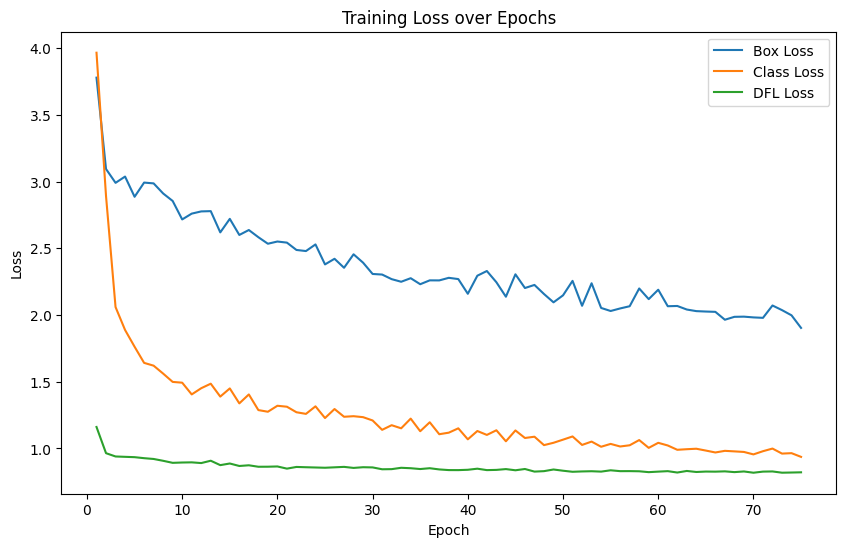

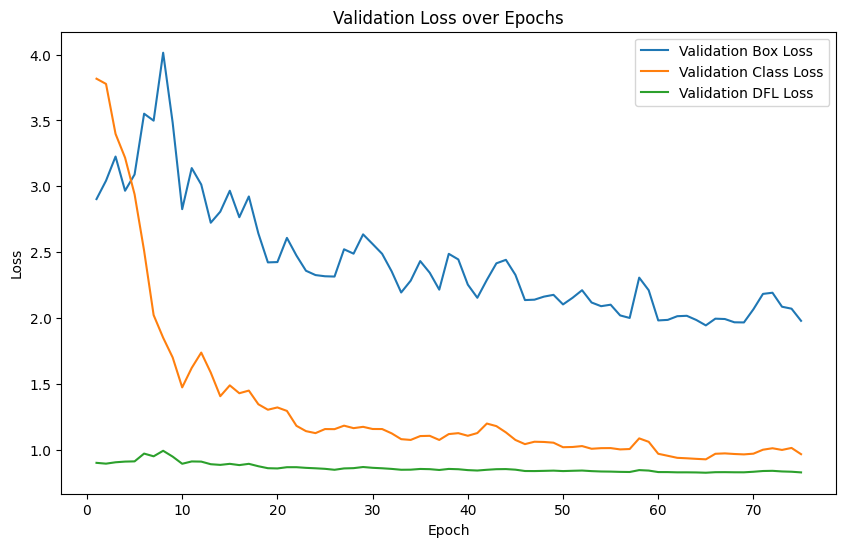

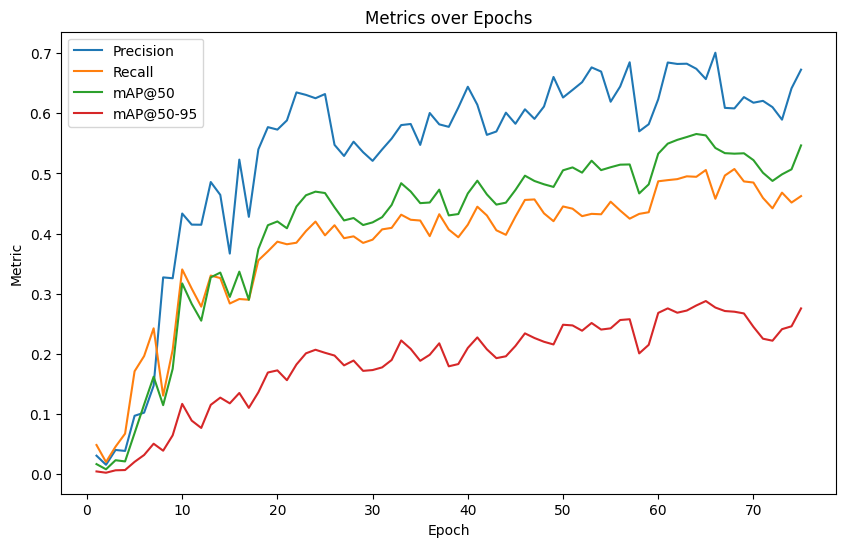

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
results_path = 'runs/detect/tokyo_vehicle_detection_two_classes/results.csv'
df = pd.read_csv(results_path)

# Strip whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the losses (train/box_loss, train/cls_loss, and train/dfl_loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation losses (val/box_loss, val/cls_loss, val/dfl_loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Validation Class Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Validation DFL Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the metrics (precision, recall, mAP@50, and mAP@50-95)
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()


## 5.2 Enhanced model

In [ ]:
from ultralytics import YOLO

# Define the checkpoint save path in the Tokyo folder
checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'

# Load a larger YOLO model (try 'yolov8l.pt' or 'yolov8x.pt' for larger models)
model = YOLO('yolov8l.pt')  # Switching to an even larger YOLO model

# Train the model using the dataset configuration with various improvements
model.train(
    data='/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml',  # Path to the YAML config
    epochs=300,            # Further increase in epochs
    patience=40,           # Higher patience for early stopping
    imgsz=768,             # Further increased image size for better detail capture
    batch=8,               # Larger batch size (adjust based on memory)
    lr0=1e-4,              # Lowered initial learning rate for more stable training
    lrf=0.01,              # Reduced final learning rate
    mosaic=1.0,            # Enable mosaic augmentation for better generalization
    mixup=0.5,             # Enable mixup augmentation for variety
    copy_paste=True,       # Enable CopyPaste augmentation
    freeze=[0, 1, 2],      # Freeze first few layers to focus on task-specific layers
    augment=True,          # Enable data augmentation
    auto_augment="randaugment",  # Enable RandAugment for better generalization
    name='tokyo_vehicle_detection_two_classes_larger',  # Model name for saving
    save=True              # Save the best model weights automatically
)

# Save the trained model checkpoint to a .pt file
model_path = model.ckpt_path if hasattr(model, 'ckpt_path') else model.weights[-1]
model.save(checkpoint_path)
print(f"Model checkpoint saved to: {checkpoint_path}")


Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml, epochs=300, time=None, patience=40, batch=8, imgsz=768, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=tokyo_vehicle_detection_two_classes_larger, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/train/labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/labels.cache... 20 images, 1 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs/detect/tokyo_vehicle_detection_two_classes_larger/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0005), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to runs/detect/tokyo_vehicle_detection_two_classes_larger
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      16.1G      3.252      4.053      1.272       4833        768: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         21       3405    0.00074    0.00129   0.000373   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      12.8G      2.393      3.224     0.9923       3360        768: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]

                   all         21       3405   0.000458   0.000482   0.000237   4.75e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      12.7G      2.445      2.179     0.9895       3392        768: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         21       3405    0.00322    0.00337    0.00162   0.000463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300        15G      2.208      1.608     0.9662       2122        768: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         21       3405      0.025     0.0349     0.0132    0.00489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      15.1G      2.199      1.405     0.9485       4029        768: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         21       3405     0.0376     0.0583     0.0206    0.00641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      12.7G      2.179      1.364     0.9483       3387        768: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         21       3405    0.00225    0.00289    0.00113   0.000245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      14.9G      2.167      1.295     0.9372       3242        768: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         21       3405    0.00074    0.00171   0.000434   6.32e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      9.56G      2.124       1.26     0.9356       3841        768: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         21       3405      0.021     0.0641      0.011    0.00581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      10.9G       2.06      1.175     0.9219       4018        768: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         21       3405     0.0438     0.0847     0.0238     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      14.6G      2.221      1.267     0.9372       2330        768: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         21       3405      0.166      0.344      0.134     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      14.8G      2.157      1.241     0.9278       5270        768: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         21       3405      0.225      0.469      0.284      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      12.1G      2.055      1.168     0.9166       2823        768: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         21       3405      0.263      0.575      0.376      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      16.8G      2.078      1.148     0.9119       3373        768: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         21       3405      0.292      0.665      0.525      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      16.6G      2.018      1.118     0.9163       4935        768: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         21       3405      0.672      0.485      0.551      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300        12G      2.108      1.137     0.9112       3337        768: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         21       3405      0.635      0.496       0.54      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.8G      1.957      1.131     0.9131       1839        768: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         21       3405       0.68      0.501      0.574      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      14.2G       1.94      1.086     0.8999       3245        768: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         21       3405      0.738      0.513      0.606      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      15.8G      2.007      1.114     0.8985       4333        768: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         21       3405      0.672      0.527       0.61      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      10.2G      1.904      1.063     0.8999       3530        768: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         21       3405      0.624      0.538        0.6      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      16.7G      1.987      1.108     0.9068       4056        768: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         21       3405      0.636      0.538      0.596       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      14.7G      1.924      1.065     0.8935       4027        768: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         21       3405      0.679      0.546      0.611      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      14.1G      1.956      1.085     0.8912       3755        768: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         21       3405      0.703      0.545      0.639      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      14.9G      1.925      1.086     0.8954       3098        768: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         21       3405      0.672      0.559      0.634      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      14.5G      1.932      1.034     0.8848       2647        768: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         21       3405      0.687      0.568      0.646      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      10.9G      1.831       1.02     0.8924       4099        768: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         21       3405      0.715      0.552      0.645      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      15.6G      1.842      1.012      0.879       4322        768: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         21       3405      0.754      0.553       0.65      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300        16G      1.856      1.041     0.8859       2901        768: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         21       3405      0.742      0.544      0.646      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      12.7G      1.914      1.026     0.8769       3342        768: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         21       3405      0.717      0.531      0.629      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      14.4G      1.869      1.004     0.8832       3346        768: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         21       3405      0.618      0.579      0.596      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      13.2G      1.921      1.041     0.8884       2796        768: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         21       3405      0.685      0.558      0.606      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      13.8G      1.852      1.004     0.8869       3325        768: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         21       3405      0.747      0.588      0.656      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      21.7G      1.878      1.004     0.8793       3674        768: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         21       3405       0.76      0.572      0.657      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      15.1G      1.861      1.017      0.874       3811        768: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         21       3405      0.801      0.555      0.658      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      13.9G       1.85     0.9738     0.8814       3260        768: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         21       3405      0.739      0.566      0.655      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      11.5G      1.848     0.9964     0.8811       3022        768: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         21       3405      0.719      0.541      0.632      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      11.3G      1.787     0.9805     0.8747       2460        768: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         21       3405      0.764      0.524      0.645      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      12.8G      1.836     0.9662     0.8786       3749        768: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         21       3405      0.742      0.557      0.656      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      9.45G       1.74      0.946     0.8745       2760        768: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         21       3405      0.738      0.604      0.673      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      13.8G      1.735     0.9479     0.8751       2150        768: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         21       3405      0.751      0.593      0.671      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      13.9G      1.761     0.9563     0.8681       3380        768: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         21       3405      0.747      0.585      0.671      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      12.7G      1.798     0.9617     0.8717       3727        768: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         21       3405      0.728       0.55      0.652      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      12.1G       1.74     0.9185     0.8739       3147        768: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         21       3405      0.753      0.578      0.661      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      13.1G      1.661     0.9095     0.8624       3110        768: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         21       3405      0.752      0.591       0.67        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300        12G      1.701     0.9301     0.8686       3632        768: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         21       3405      0.751      0.601      0.676      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      10.6G      1.682     0.9354       0.87       4541        768: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         21       3405      0.705      0.584      0.662      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      9.96G      1.667     0.9033      0.866       3560        768: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         21       3405      0.737      0.572      0.645      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      14.6G      1.738     0.9213     0.8598       4492        768: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         21       3405      0.722      0.577       0.65      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      13.9G      1.705     0.9266     0.8735       2741        768: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         21       3405      0.752      0.562      0.656       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      9.97G      1.732     0.9429     0.8785       3099        768: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         21       3405      0.759      0.583      0.682      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      14.3G      1.658     0.8781     0.8647       3316        768: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         21       3405      0.747      0.614      0.698      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# from ultralytics import YOLO

# # Define the checkpoint save path in the Tokyo folder
# checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'

# # Load a larger YOLO model (try 'yolov8s.pt' or 'yolov8m.pt' for small/medium)
# model = YOLO('yolov8m.pt')  # Switching to a larger YOLO model

# # Train the model using the dataset configuration with various improvements
# model.train(
#     data='/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml',  # Path to the YAML config
#     epochs=200,            # Increased number of epochs
#     patience=20,           # Increased patience to allow more epochs without improvement
#     imgsz=640,             # Increased image size for better detail capture
#     batch=8,               # Increased batch size (if memory allows)
#     lr0=1e-4,              # Lowered initial learning rate for more stable training
#     lrf=0.01,              # Reduced final learning rate
#     mosaic=1.0,            # Enable mosaic augmentation for better generalization
#     freeze=[0, 1, 2],      # Freeze first few layers to focus on task-specific layers
#     augment=True,          # Enable data augmentation
#     auto_augment="randaugment",  # Enable RandAugment for better generalization
#     name='tokyo_vehicle_detection_two_classes',  # Model name for saving
#     save=True              # Save the best model weights automatically
# )

# # Save the trained model checkpoint to a .pt file
# model_path = model.ckpt_path if hasattr(model, 'ckpt_path') else model.weights[-1]
# model.save(checkpoint_path)
# print(f"Model checkpoint saved to: {checkpoint_path}")


Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml, epochs=200, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=tokyo_vehicle_detection_two_classes3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

train: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/train/labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/labels... 20 images, 1 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 84.57it/s]


val: New cache created: /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/labels.cache
Plotting labels to runs/detect/tokyo_vehicle_detection_two_classes3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/tokyo_vehicle_detection_two_classes3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      7.55G      3.544      3.994      1.216       1681        640: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         21       3405     0.0191     0.0297     0.0103    0.00288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      7.25G       2.76      3.354     0.9854       2409        640: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         21       3405     0.0191     0.0297     0.0103    0.00288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200         9G      2.518      2.329     0.9413       1488        640: 100%|██████████| 10/10 [00:01<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         21       3405     0.0191     0.0297     0.0103    0.00288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      8.39G       2.51      1.733     0.9235       2409        640: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         21       3405    0.00441    0.00727    0.00268   0.000607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      7.26G      2.438      1.498     0.9197       2188        640: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         21       3405     0.0245      0.065     0.0134    0.00484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      5.57G      2.339      1.454     0.9202       2240        640: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         21       3405      0.041      0.165     0.0354     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      6.23G       2.34      1.352     0.8979       2166        640: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         21       3405     0.0374       0.19     0.0252    0.00734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.48G      2.331      1.318     0.8951       3036        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         21       3405     0.0313     0.0832     0.0172    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.01G      2.275      1.258     0.8819       2131        640: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         21       3405     0.0455      0.114      0.026    0.00839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       7.5G      2.224      1.232     0.8872       2065        640: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         21       3405      0.132      0.337      0.146     0.0731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.65G      2.275      1.286     0.8965       1974        640: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         21       3405      0.184      0.441      0.208     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      6.33G      2.139      1.179     0.8925       2119        640: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         21       3405      0.229      0.504      0.297      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      7.17G      2.209       1.21     0.8853       2979        640: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         21       3405      0.265      0.523      0.346      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      6.39G      2.148      1.195     0.8818       1656        640: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         21       3405      0.517      0.409      0.407      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       6.7G      2.138      1.178     0.8785       4084        640: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         21       3405       0.57      0.419      0.457      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.71G      2.257      1.186     0.8845       2975        640: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         21       3405      0.569      0.428      0.468      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      5.65G      2.234      1.161     0.8613       3036        640: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         21       3405      0.552      0.422      0.451       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       7.8G      2.134      1.121     0.8659       2334        640: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         21       3405      0.585      0.455      0.501      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      5.63G      2.062      1.087     0.8676       3173        640: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         21       3405      0.623      0.452      0.519      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       7.4G      2.088       1.09     0.8684       2648        640: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         21       3405      0.601      0.477      0.529      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       8.5G      2.178      1.142     0.8731       1605        640: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         21       3405      0.602      0.518      0.555      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      5.58G      2.163      1.112     0.8695       1760        640: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         21       3405      0.598      0.467      0.504      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200       8.7G      2.133      1.082     0.8587       2795        640: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         21       3405      0.574      0.482      0.496      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      6.39G      2.096      1.071     0.8539       1933        640: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         21       3405      0.605      0.478       0.51      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      5.84G      2.071      1.048     0.8569       2046        640: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         21       3405      0.657      0.478       0.54       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      5.63G      2.023      1.067     0.8597       2701        640: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         21       3405      0.643      0.529      0.582      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      7.59G      2.001      1.015     0.8572       2433        640: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         21       3405      0.668      0.495      0.562      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      6.68G      2.128      1.052     0.8559       2004        640: 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         21       3405       0.68      0.494       0.56       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      6.48G      1.971      1.031     0.8574       1831        640: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         21       3405      0.614      0.507       0.55      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      6.05G      2.123       1.02     0.8551       3563        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         21       3405      0.516      0.509      0.492      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      6.74G      1.877      0.981       0.85       2350        640: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         21       3405      0.601      0.444      0.495      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      6.49G      1.975      1.017     0.8637       1008        640: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         21       3405      0.632      0.455      0.529      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      5.96G      1.904     0.9921     0.8569       2075        640: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         21       3405      0.701      0.476      0.567        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      7.37G      1.954     0.9815     0.8579       3762        640: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         21       3405      0.676      0.505      0.577      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      7.83G      1.867     0.9458     0.8512       2737        640: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         21       3405      0.693      0.493      0.576      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      8.45G      1.945     0.9928     0.8527       1964        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         21       3405      0.684      0.476      0.561      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      8.64G       2.02     0.9951     0.8454       3264        640: 100%|██████████| 10/10 [00:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         21       3405      0.615       0.48       0.52      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       6.5G      1.883     0.9691     0.8472       2135        640: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         21       3405      0.601      0.531      0.558      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      6.96G       1.82     0.9229     0.8413       1567        640: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         21       3405      0.629      0.556      0.601      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      7.12G       1.82     0.9208     0.8492       1522        640: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         21       3405      0.686      0.535      0.622      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.12G      1.847     0.9502      0.851       1889        640: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         21       3405      0.668      0.553      0.609      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      5.72G      1.869     0.9359     0.8439       2341        640: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         21       3405      0.728       0.46      0.558      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.36G      1.845     0.9001     0.8442       2778        640: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         21       3405      0.689      0.474       0.55      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      7.03G      1.856     0.9323     0.8456       1671        640: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         21       3405      0.679      0.447      0.529      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      7.43G      1.969      1.003     0.8447       1970        640: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         21       3405       0.67      0.443       0.53      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      5.89G      1.917      0.958     0.8369       2474        640: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         21       3405      0.662      0.529      0.609      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       6.3G      1.873     0.9277     0.8453       2360        640: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         21       3405      0.661      0.545      0.612       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.64G      1.786     0.9016     0.8393       1978        640: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         21       3405      0.663      0.551      0.619       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      7.18G      1.814     0.9181     0.8526       2601        640: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         21       3405      0.648      0.566      0.622      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      6.69G      1.892      0.921     0.8477       2167        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         21       3405      0.676      0.545      0.621       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      6.76G      1.821     0.9017     0.8352       2256        640: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         21       3405      0.682      0.534      0.609      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      6.53G      1.798     0.8971     0.8403       1677        640: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         21       3405       0.69      0.542      0.616      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      7.15G      1.818     0.9012     0.8427       2353        640: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         21       3405      0.693      0.553      0.615      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      7.46G      1.844     0.9218     0.8364       2576        640: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         21       3405      0.693       0.54      0.611      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      7.02G      1.736     0.8497      0.843       2146        640: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         21       3405      0.713       0.52      0.609      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      7.39G      1.735     0.8579     0.8366       2501        640: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         21       3405      0.697      0.516      0.598      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      7.93G      1.748      0.891     0.8394       2122        640: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         21       3405      0.707      0.525      0.603      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      7.52G      1.816     0.8756     0.8368       2759        640: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         21       3405      0.682      0.531      0.602      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      9.06G      1.808     0.8922     0.8394       1721        640: 100%|██████████| 10/10 [00:01<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         21       3405      0.665      0.533      0.587       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      7.26G      1.832      0.866     0.8324       3222        640: 100%|██████████| 10/10 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         21       3405      0.659       0.54      0.577      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      7.66G      1.724     0.8798     0.8457       1914        640: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         21       3405       0.66      0.531      0.582      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       7.4G      1.781     0.8692     0.8363       1966        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         21       3405      0.716      0.546      0.633       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      5.86G      1.746     0.8585     0.8274       2648        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         21       3405       0.72      0.568      0.649       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      6.99G      1.802     0.8563     0.8337       2271        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         21       3405      0.721      0.568      0.647      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       8.6G       1.79      0.875     0.8345       2931        640: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         21       3405      0.705      0.551      0.628      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      6.36G      1.733     0.8537     0.8365       2145        640: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

                   all         21       3405      0.645      0.586      0.608      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      6.68G      1.681      0.837     0.8331       3264        640: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         21       3405      0.674      0.591      0.637       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      8.05G      1.686     0.8268      0.831       2295        640: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         21       3405      0.711      0.577      0.653      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      7.26G      1.673     0.8281     0.8369       3026        640: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         21       3405      0.731      0.557      0.647      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200         6G      1.693     0.8337     0.8316       2030        640: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         21       3405      0.707      0.525      0.613      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      6.25G      1.726     0.8152     0.8263       2819        640: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         21       3405      0.697      0.517      0.604      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      6.76G      1.687     0.8184     0.8273       2543        640: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         21       3405      0.686      0.542       0.61      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      6.74G      1.832     0.8405     0.8246       2951        640: 100%|██████████| 10/10 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         21       3405      0.714      0.553      0.616      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      8.78G      1.679     0.8058      0.832       1713        640: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         21       3405      0.702      0.549      0.623      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      5.36G      1.602     0.8097     0.8359       1881        640: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         21       3405      0.749      0.542      0.643      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.62G      1.761      0.844     0.8291       2564        640: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         21       3405      0.784      0.534      0.655      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      6.15G      1.669     0.8204     0.8322       2165        640: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         21       3405      0.721      0.554      0.648      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      6.48G      1.713     0.8415     0.8294       2067        640: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         21       3405      0.698      0.555      0.635      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      6.97G      1.626     0.7862     0.8258       3678        640: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         21       3405      0.674      0.556      0.612      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.08G      1.645     0.8207     0.8273       1787        640: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         21       3405      0.654      0.556        0.6      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      6.89G      1.663     0.7921     0.8228       1997        640: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         21       3405      0.759      0.511      0.613      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      6.55G      1.598     0.7873     0.8304       2789        640: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         21       3405      0.753      0.558      0.655      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      6.41G      1.638     0.7873      0.826       3041        640: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         21       3405      0.704      0.586      0.661      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       6.1G      1.611     0.7845     0.8234       2392        640: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         21       3405      0.691      0.584      0.651      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200       6.3G      1.546     0.7796     0.8281       1823        640: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         21       3405      0.682      0.573      0.632      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       6.9G       1.71      0.801     0.8287       2302        640: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         21       3405      0.678      0.539      0.579      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      7.55G      1.684     0.7841     0.8264       1861        640: 100%|██████████| 10/10 [00:01<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         21       3405      0.696      0.532      0.576      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      7.24G      1.746     0.8079     0.8265       2471        640: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         21       3405      0.724      0.536      0.591        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       6.8G      1.624     0.7965     0.8224       3781        640: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         21       3405      0.739       0.53      0.609      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      5.99G       1.56     0.7377     0.8292       2173        640: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         21       3405       0.72      0.553      0.639      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      7.45G      1.615     0.7606      0.826       1821        640: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         21       3405      0.733      0.549      0.645      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      8.13G      1.606      0.759     0.8251       1996        640: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         21       3405      0.703      0.565      0.641      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      7.79G      1.538     0.7409     0.8268       1626        640: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         21       3405      0.727      0.569      0.643       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      8.03G      1.706     0.7901     0.8337       1962        640: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         21       3405      0.745      0.578      0.652      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      7.26G      1.616     0.7522     0.8316       1658        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         21       3405      0.736      0.562       0.65      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      7.63G      1.617     0.7654      0.825       2331        640: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         21       3405      0.792      0.531       0.64      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.61G      1.764     0.8056      0.822       2886        640: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         21       3405      0.756      0.542      0.637      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       5.4G      1.538     0.7326     0.8224       2089        640: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         21       3405      0.668      0.526      0.586      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      8.07G      1.712     0.7892     0.8204       2905        640: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         21       3405      0.639      0.527      0.571      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      5.81G      1.544     0.7378     0.8219       1225        640: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         21       3405      0.658      0.519      0.571      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      5.86G      1.637     0.7814     0.8262       2615        640: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         21       3405      0.684      0.542      0.597      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      6.26G      1.641     0.7765     0.8186       2358        640: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         21       3405      0.752      0.565      0.643      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      6.42G      1.574     0.7614      0.817       1271        640: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         21       3405      0.772      0.558      0.647      0.361
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 83, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



103 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/tokyo_vehicle_detection_two_classes3/weights/last.pt, 46.8MB
Optimizer stripped from runs/detect/tokyo_vehicle_detection_two_classes3/weights/best.pt, 46.8MB

Validating runs/detect/tokyo_vehicle_detection_two_classes3/weights/best.pt...
Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 236 layers, 23,203,990 parameters, 0 gradients, 67.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


                   all         21       3405      0.685      0.562      0.641      0.363
                   Car         20       3112      0.846      0.602      0.724      0.374
                 Truck         18        293      0.524      0.522      0.558      0.353
Speed: 0.1ms preprocess, 216.3ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/tokyo_vehicle_detection_two_classes3
Model checkpoint saved to: /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
results_path = 'runs/detect/tokyo_vehicle_detection_two_classes/results.csv'
df = pd.read_csv(results_path)

# Strip whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the losses (train/box_loss, train/cls_loss, and train/dfl_loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation losses (val/box_loss, val/cls_loss, val/dfl_loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Validation Class Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Validation DFL Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the metrics (precision, recall, mAP@50, and mAP@50-95)
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()


#**6. Validation of the Model**

In [ ]:
# !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 15.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load the trained model using the YOLO class
checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'
model = YOLO(checkpoint_path)
print("Model loaded from checkpoint successfully!")

## Validation

In [ ]:
# Perform validation
metrics = model.val(
    data='/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml',  # Make sure this YAML is correct
    batch=4,
    imgsz=640,
    verbose=True
)

# Set the number of classes directly
model.model.nc = 2  # Set the number of classes to match your dataset

# Print the benchmark summary
print("Model Benchmark Summary:")
print(f"Precision: {metrics.box.map50:.4f}")   # Precision at IoU 50
print(f"Recall: {metrics.box.map50:.4f}")      # Recall at IoU 50
print(f"mAP@50: {metrics.box.map50:.4f}")      # mAP at IoU 50
print(f"mAP@50-95: {metrics.box.map:.4f}")  # mAP averaged across IoUs 50 to 95

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


val: Scanning /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/labels.cache... 20 images, 1 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


                   all         21       3405      0.698      0.584      0.661      0.383
                   Car         20       3112      0.895      0.612      0.749      0.402
                 Truck         18        293        0.5      0.556      0.573      0.363
Speed: 0.3ms preprocess, 138.7ms inference, 0.1ms loss, 77.2ms postprocess per image
Results saved to runs/detect/val3
Model Benchmark Summary:
Precision: 0.6609
Recall: 0.6609
mAP@50: 0.6609
mAP@50-95: 0.3826


## Manual review of the image


image 1/1 /content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/images/Screenshot 2022-09-02 191129.jpg: 256x512 187 Cars, 7 Trucks, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 512)


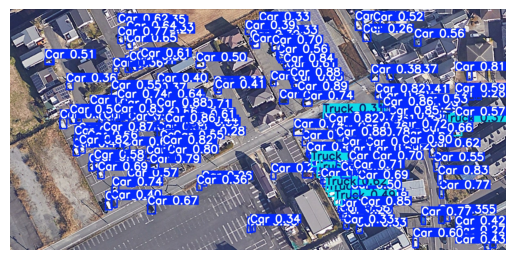

In [ ]:
# Visualize predictions on a validation image
validation_image_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/images/Screenshot 2022-09-02 191129.jpg'

# Run inference on the image
results = model(validation_image_path)

# Access the first result (assuming you passed one image)
result = results[0]

# Save the image with bounding boxes drawn
result.save()

# Since the image is saved at '/content/results_Screenshot 2022-09-02 191339.jpg'
predicted_image_path = '/content/results_Screenshot 2022-09-02 191129.jpg'

# Load and display the image with bounding boxes
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved image
img = Image.open(predicted_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


# **7. Using the model**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 16.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the trained model from the checkpoint
checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'
model = YOLO(checkpoint_path)
print("Model loaded from checkpoint successfully!")

# Path to outside test images folder
test_images_dir = '/content/drive/MyDrive/aerial_image_recognition/img/test_images/'

# List of test images you want to test
test_images = [
    'namyslowska.jpg',
    'ursynow.jpg',
    'centralny.jpg' # Replace with the actual image filenames in the test_images folder
    # Add more images as necessary
]

# Loop through the images and run inference
for image_name in test_images:
    image_path = os.path.join(test_images_dir, image_name)
    # Run inference on the image
    results = model(image_path)

    # Access the first result in the results list and save the image
    results[0].save()  # Save the image with predictions to the dynamically created directory

    # Get the exact path where the image is saved
    predicted_image_path = os.path.join(results[0].save_dir, image_name)  # Dynamically get the save directory

    # Load and display the image with bounding boxes
    if os.path.exists(predicted_image_path):
        img = Image.open(predicted_image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()

        print(f"Predictions saved and displayed for {image_name}")
    else:
        print(f"Predicted image not found: {predicted_image_path}")


Model loaded from checkpoint successfully!

image 1/1 /content/drive/MyDrive/aerial_image_recognition/img/test_images/namyslowska.jpg: 320x640 56 Cars, 2 Trucks, 628.9ms
Speed: 3.6ms preprocess, 628.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Predicted image not found: runs/detect/predict/namyslowska.jpg

image 1/1 /content/drive/MyDrive/aerial_image_recognition/img/test_images/ursynow.jpg: 288x640 76 Cars, 11 Trucks, 928.8ms
Speed: 3.1ms preprocess, 928.8ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)
Predicted image not found: runs/detect/predict/ursynow.jpg


Model loaded from checkpoint successfully!

image 1/1 /content/drive/MyDrive/aerial_image_recognition/img/test_images/boduena.jpg: 384x640 212 Cars, 5 Trucks, 1155.8ms
Speed: 8.3ms preprocess, 1155.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


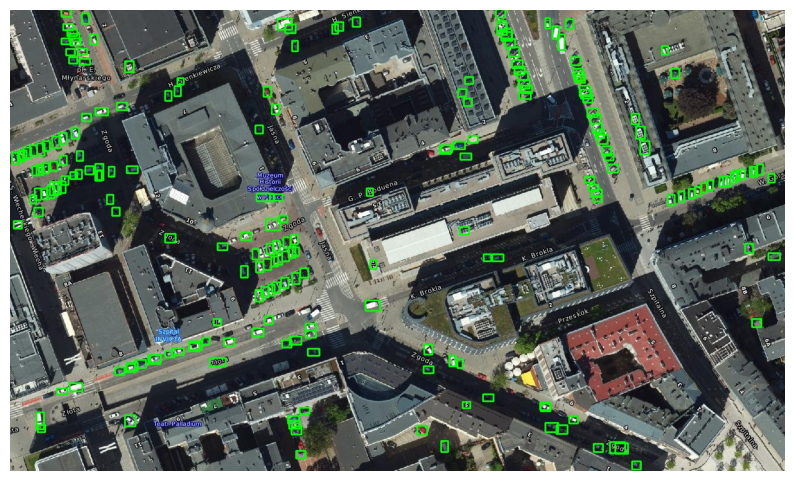

Predictions with car boxes (conf > 0.4) saved and displayed for boduena.jpg

image 1/1 /content/drive/MyDrive/aerial_image_recognition/img/test_images/brechta.jpg: 384x640 81 Cars, 3 Trucks, 1040.9ms
Speed: 9.4ms preprocess, 1040.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


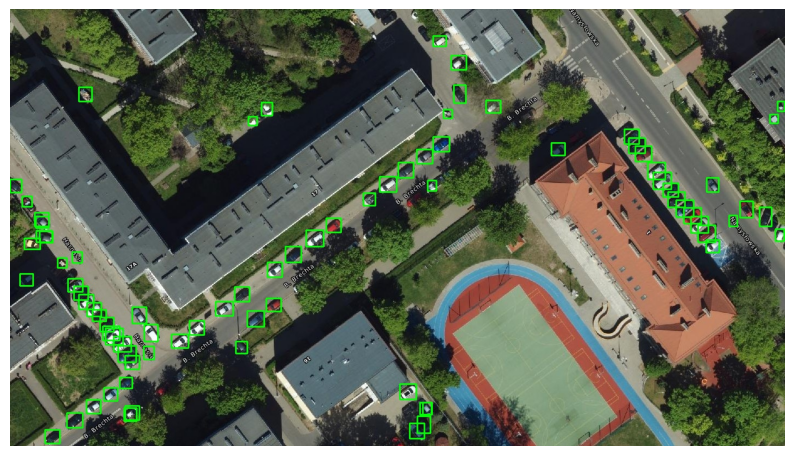

Predictions with car boxes (conf > 0.4) saved and displayed for brechta.jpg


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

# Load the trained model from the checkpoint
checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'
model = YOLO(checkpoint_path)
print("Model loaded from checkpoint successfully!")

# Path to outside test images folder
test_images_dir = '/content/drive/MyDrive/aerial_image_recognition/img/test_images/'

# List of test images you want to test
test_images = [
    'boduena.jpg',
    'brechta.jpg',
    # Replace with the actual image filenames in the test_images folder
]

# Loop through the images and run inference
for image_name in test_images:
    image_path = os.path.join(test_images_dir, image_name)

    # Run inference on the image
    results = model(image_path)

    # Access the first result
    result = results[0]

    # Load the original image using OpenCV
    img = cv2.imread(image_path)

    # Loop through the results and draw only the bounding boxes for cars with confidence > 0.4
    for box in result.boxes:
        if box.cls == 0 and box.conf > 0.2:  # cls == 0 for 'Car' class, and conf > 0.4 for confidence
            x1, y1, x2, y2 = box.xyxy[0]  # Get the bounding box coordinates
            color = (0, 255, 0)  # Define a color for the bounding box (green)
            thickness = 2  # Define the thickness of the bounding box line
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    # Save the image without labels in a new directory
    save_dir = os.path.join('runs', 'detect', 'cars_over_0.4')  # Customize directory
    os.makedirs(save_dir, exist_ok=True)
    predicted_image_path = os.path.join(save_dir, image_name)
    cv2.imwrite(predicted_image_path, img)  # Save the image with bounding boxes

    # Load and display the image with bounding boxes
    img_pil = Image.open(predicted_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_pil)
    plt.axis('off')  # Hide axes
    plt.show()

    print(f"Predictions with car boxes (conf > 0.4) saved and displayed for {image_name}")


Model loaded from checkpoint successfully!

0: 640x640 1 Car, 1 Truck, 1385.8ms
Speed: 4.7ms preprocess, 1385.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Trucks, 1409.2ms
Speed: 4.2ms preprocess, 1409.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 Cars, 9 Trucks, 2137.6ms
Speed: 4.7ms preprocess, 2137.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x64 2 Trucks, 265.6ms
Speed: 3.0ms preprocess, 265.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 64)

0: 512x640 5 Cars, 3 Trucks, 1112.8ms
Speed: 3.7ms preprocess, 1112.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 3 Cars, 8 Trucks, 1529.9ms
Speed: 5.1ms preprocess, 1529.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 Cars, 6 Trucks, 1751.3ms
Speed: 7.4ms preprocess, 1751.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x96 1

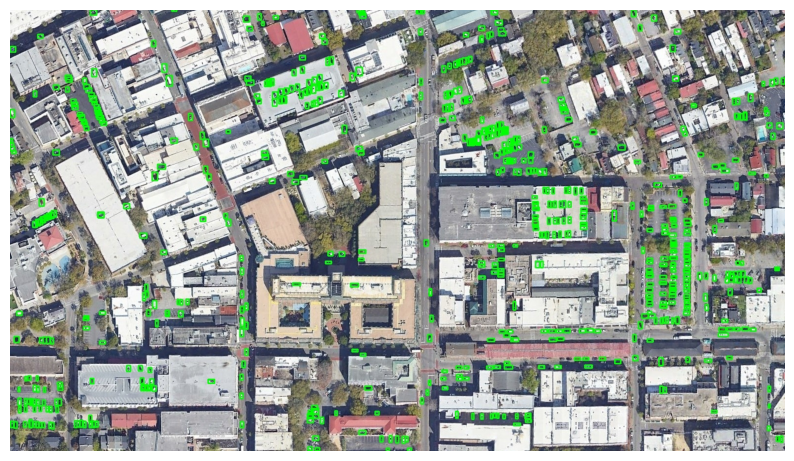

Predictions with car boxes (conf > 0.4) saved and displayed for charleston.jpg


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import numpy as np

# Load the trained model from the checkpoint
checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'
model = YOLO(checkpoint_path)
print("Model loaded from checkpoint successfully!")

# Path to outside test images folder
test_images_dir = '/content/drive/MyDrive/aerial_image_recognition/img/test_images/'

# List of test images you want to test
test_images = [
    'charleston.jpg'  # Replace with the actual image filenames in the test_images folder
]

# Function to split the image into smaller tiles
def split_image(image, tile_size):
    h, w = image.shape[:2]
    tiles = []
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            tile = image[y:y+tile_size, x:x+tile_size]
            tiles.append((tile, x, y))  # Return the tile and its coordinates
    return tiles

# Loop through the images and run inference on each tile
for image_name in test_images:
    image_path = os.path.join(test_images_dir, image_name)

    # Load the original image using OpenCV
    img = cv2.imread(image_path)

    # Split the image into smaller tiles (e.g., 512x512 pixels)
    tile_size = 512
    tiles = split_image(img, tile_size)

    # Create a copy of the image to draw results on
    img_with_boxes = img.copy()

    # Loop through the tiles and run inference
    for tile, x_offset, y_offset in tiles:
        # Run inference on the tile
        results = model(tile)

        # Access the first result
        result = results[0]

        # Loop through the results and draw only the bounding boxes for cars with confidence > 0.4
        for box in result.boxes:
            if box.cls == 0 and box.conf > 0.2:  # cls == 0 for 'Car' class, and conf > 0.4 for confidence
                # Clone the tensor to allow in-place modification
                x1, y1, x2, y2 = box.xyxy[0].clone()

                # Adjust the coordinates relative to the full image
                x1 += x_offset
                y1 += y_offset
                x2 += x_offset
                y2 += y_offset

                color = (0, 255, 0)  # Define a color for the bounding box (green)
                thickness = 2  # Define the thickness of the bounding box line
                cv2.rectangle(img_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    # Save the full image with bounding boxes in a new directory with high quality
    save_dir = os.path.join('runs', 'detect', 'cars_over_0.4')  # Customize directory
    os.makedirs(save_dir, exist_ok=True)
    predicted_image_path = os.path.join(save_dir, image_name)

    # Save the image with high quality (for JPEG format)
    cv2.imwrite(predicted_image_path, img_with_boxes, [cv2.IMWRITE_JPEG_QUALITY, 95])  # Set quality to 95 for JPEG

    # Load and display the full image with bounding boxes
    img_pil = Image.open(predicted_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_pil)
    plt.axis('off')  # Hide axes
    plt.show()

    print(f"Predictions with car boxes (conf > 0.4) saved and displayed for {image_name}")


In [ ]:
from collections import Counter
import os
from ultralytics import YOLO

# Load the trained model
checkpoint_path = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/yolov8_tokyo_checkpoint.pt'
model = YOLO(checkpoint_path)

# Path to the validation images and labels
val_images_dir = '/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/val/images'
val_images = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

# Define your class names as per your dataset
class_names = ['Car', 'Motorbike', 'Truck', 'Pickup Truck', 'Van', 'Truck with Trailer', 'Bus', 'Bicycle', 'Miscellaneous', 'Car-Trailer']

# Initialize a counter to count predictions for each class
predicted_count = Counter()

# Run inference on the validation set
for img_name in val_images:
    img_path = os.path.join(val_images_dir, img_name)

    # Run inference
    results = model(img_path)

    # Get the predicted classes for this image
    for result in results:
        boxes = result.boxes  # Get bounding boxes and classes

        for box in boxes:
            class_id = int(box.cls)  # Class index
            predicted_count[class_names[class_id]] += 1  # Increment the counter for the predicted class

# Print the predicted class distribution in the validation set
print("Predicted count of vehicle types in the validation set:")
for vehicle_type, count in predicted_count.items():
    print(f"{vehicle_type}: {count}")


In [ ]:
# history = model.train(
#     data='/content/drive/MyDrive/aerial_image_recognition/img/train/Tokyo/coco_tokyo.yaml',
#     epochs=50,
#     imgsz=640,
#     batch=16,
#     save=True
# )

# # Plot training and validation loss
# import matplotlib.pyplot as plt

# train_loss = history['train']['box_loss']  # Adjust based on available keys
# val_loss = history['val']['box_loss']  # Adjust based on available keys

# plt.plot(train_loss, label='Train Loss')
# plt.plot(val_loss, label='Val Loss')
# plt.title('Training and Validation Loss Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
